In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics

from IPython.display import display, clear_output
from PIL import Image, ImageSequence

In [2]:
!nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-a8053574-4128-877c-acfd-80334fa7cd5d)


In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [ ]:
from data import load_data
x = load_data("x_array_qqq.npy", allow_pickle = True)

In [ ]:
np.shape(x[0,0,qq, noise])

In [6]:
model_all = tf.keras.models.load_model("model_all_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_Fixed_3_512")

2023-11-20 02:32:02.956732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 02:32:03.579188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [ ]:
model_qq = tf.keras.models.load_model("model_qq_v2")

Below are two cells that evaluate every point in our discritized space of weights and store to a dictionary, evaluation can be stopped at any point, saving after every signal fraction

In [28]:
import time
start_time = time.time()

def evaluate_loss_landscape_4Features(model, m1, m2):
    
    Nfeatures = 4
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}FeaturesHD.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    
    losses_list = []

    epsilon = 1e-6
    sig_space = np.logspace(-3, -1, 20)
    
    #if we want a specific sigfrac
    #sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
            
        print("Signal Fraction: ", sig)
        for w1 in weight_list:
            for w2 in weight_list:
                
                #print(w1, w2)
                sigfrac = sig
                
                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                key = (sig,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

In [13]:
import time
start_time = time.time()

def evaluate_loss_landscape_6Features(model, m1, m2):
    
    Nfeatures = 6
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}FeaturesHD.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-6
    sig_space = np.logspace(-3, -1, 20)
    
    #if we want a specific sigfrac
    #sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        for w1 in weight_list:
            for w2 in weight_list:
                #print(w1, w2)
                sigfrac = sig

                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq]))
                train_background = int(1/4 * len(x[0,0,qq]))
                train_data = int(1/4 * len(x[0,0,qq]))
                train_reference = int(1/4 * len(x[0,0,qq]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq])))
                signal = x[m1, m2,qq][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Signal Fraction:  0.001
Signal Fraction:  0.0012742749857031334
Signal Fraction:  0.001623776739188721
Signal Fraction:  0.00206913808111479
Signal Fraction:  0.0026366508987303583
Signal Fraction:  0.003359818286283781
Signal Fraction:  0.004281332398719396
Signal Fraction:  0.00545559478116852
Signal Fraction:  0.0069519279617756054
Signal Fraction:  0.008858667904100823
Signal Fraction:  0.011288378916846888
Signal Fraction:  0.01438449888287663
Signal Fraction:  0.018329807108324356
Signal Fraction:  0.023357214690901212
Signal Fraction:  0.029763514416313176
Signal Fraction:  0.0379269019073225
Signal Fraction:  0.04832930238571752
Signal Fraction:  0.06158482110660261
Signal Fraction:  0.07847599703514611
Signal Fraction:  0.1


Below we have a loss landscape using an overfitted prior (Kept for memorial purposes...)

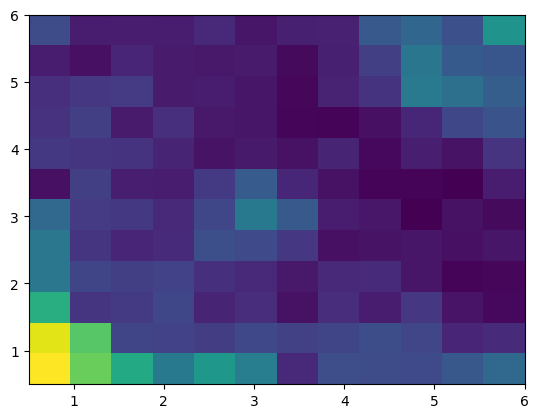

In [415]:
loss_values = list(z[sig_space[0], 1, 5.5])

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [ ]:
def loss_landscape_nofit(sigfrac, m1, m2, z, step=0.25):
    start = 0.5
    end = 6
    step = step
    
    weight_list = np.arange(start, end + step, step)
    grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)
    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    bins = int(np.sqrt(len(z[sigfrac, m1, m2])))

    star1_coords = (m1, m2)
    star2_coords = (m2, m1)

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(w1_values, w2_values, bins=(bins, bins), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.colorbar(label='Loss (BCE)')
    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    plt.legend()
    plt.show()
    
    return h
loss_landscape_nofit(0.001, 3, 3, z_allm1m2_6HD);

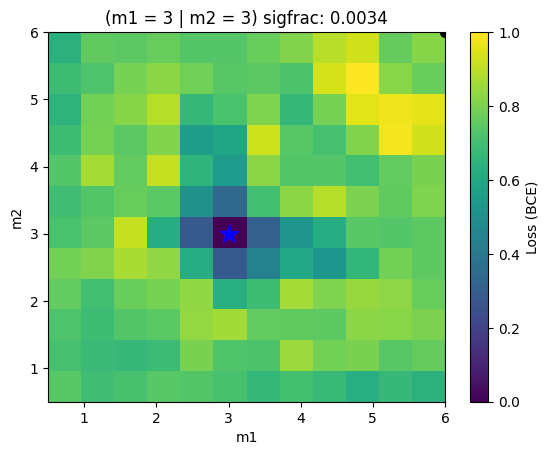

In [125]:
def loss_landscape_2D(sigfrac, m1, m2, w1_out, w2_out, z):
    m1_values, m2_values = zip(*grid_axes.keys())

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('(m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    return h

loss_landscape_2D(sig_space[5], 3, 3, 6, 6, z);

Final weight coordinates: w1 = 2.9546401500701904  w2 = 4.470359802246094 


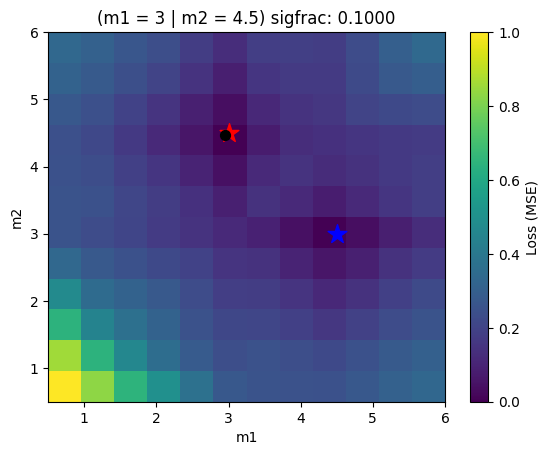

In [805]:
def animate(sigfrac, m1, m2, w1, w2, epochs, z):
    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        plt.figure()
        loss_landscape(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
        plt.show()
        clear_output(wait=True)
        
    loss_landscape(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
    print("Final weight coordinates: w1 = {} ".format(w1_fit_coord) + " w2 = {} ".format(w2_fit_coord))
        
sigfrac = sig_list[19]
w1, w2 = 2, 3
m1, m2 = 3, 4.5
epochs = 50
animate(sigfrac, m1, m2, w1, w2, epochs, z345)

Final weight coordinates: w1 = 0.997785210609436  w2 = 5.534912109375 


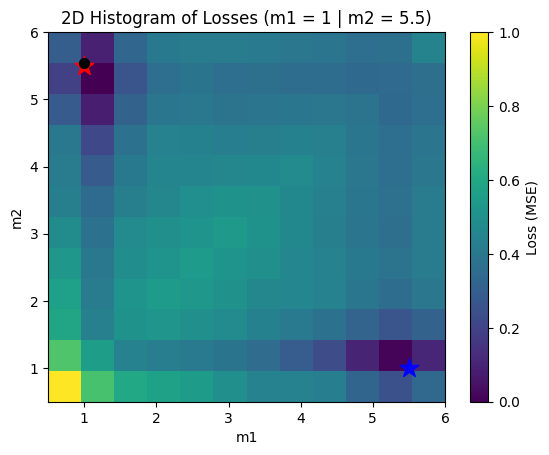

In [540]:
def animate_random(sigfrac, m1,m2, w1, w2, epochs, z):
    print(f"Initial Weights: {w1} {w2}")
    animate(sigfrac, m1, m2, w1, w2, epochs, z)
    
sigfrac = 0.05
random_number1 = random.uniform(0.1, 6.0)
random_number2 = random.uniform(0.1, 6.0)
m1, m2 = 1, 5.5
epochs = 50

animate_random(sigfrac, m1,m2, random_number1, random_number2, 50, z)

In [169]:
#save images to make them gifs
def create_gif_fitout(sigfrac, m1, m2, w1, w2, z, epochs):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)

        image_path = os.path.join(output_directory, f'hist_{key}.png')
        plt.savefig(image_path)
        plt.close()

        clear_output(wait=True)
        
    #make the gif
    frames = []

    image_dir = '2dhist_images'
    image_files = os.listdir(image_dir)

    image_files = sorted([filename for filename in os.listdir(image_dir) if filename.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    for filename in image_files:
        image = Image.open(os.path.join(image_dir, filename))
        frames.append(image)
        os.remove(image_dir+"/"+filename)

    output_gif_filename = f'{sigfrac, m1, m2, w1, w2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=200, loop=0)

In [193]:
w1 = random.uniform(0.5, 6.0)
w2 = random.uniform(0.5, 6.0)

print(w1, w2)
sigfrac = sig_space[10]
m1 = 3
m2 = 4.5
epochs = 50
create_gif_fitout(sigfrac, m1, m2, w1, w2, z_allm1m2, epochs)

3.736706332731714 3.002639396491747
Signal Fraction:  0.011288378916846888
30/30 [==============================] - 0s 7ms/step - loss: 0.6916 - val_loss: 0.6915
3 4.5 4.562472 2.8867893


In [172]:
sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    m1, m2 = 1, 5.5
    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    epochs = 50
    frames = create_gif_fitout(sigfrac, m1, m2, w1, w2, z_allm1m2, epochs)

In [1]:
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        frames.append(Image.open(image_path))

    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)